# RDN applied to social influence echo chamber model

> CITATION NEEDED

#### imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import logging
import os
import datetime
import itertools
import vaex
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, Normalize
from matplotlib.cm import ScalarMappable
from pathlib import Path
from tqdm.notebook import tqdm


from opdynamics.metrics.opinions import sample_means
from opdynamics.utils.constants import *
from opdynamics.utils.decorators import optional_fig_ax, hash_repeat
from opdynamics.utils.plot_utils import colorbar_inset, colorline

from social_influence_echo_chamber_model.echo_chamber_dynamics import (
    EchoChamberDynamics,
)
from social_influence_echo_chamber_model.analysis import screen_diversity, num_opinion_peaks

np.random.seed(1337)
sns.set_theme(
    context="notebook",
    style="ticks",
    rc={
        "pdf.fonttype": 42,  # embed font in output
        "svg.fonttype": "none",  # embed font in output
        "figure.facecolor": "white",
        "figure.dpi": 200,
        "axes.facecolor": "None",
        "axes.spines.left": True,
        "axes.spines.bottom": True,
        "axes.spines.right": False,
        "axes.spines.top": False,
    },
)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["svg.fonttype"] = "none"

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
)
logger = logging.getLogger("nb-social")


In [3]:
@optional_fig_ax
def plot_agents(
    df,
    color_code=True,
    subsample: int = 1,
    ax: plt.Axes = None,
    fig: plt.Figure = None,
    **kwargs
):
    cmap = kwargs.pop("cmap", OPINIONS_CMAP)
    vmin = kwargs.pop("vmin", np.min(df.values))
    vmax = kwargs.pop("vmax", np.max(df.values))
    lw = kwargs.pop("lw", 0.1)

    try:
        sm = ScalarMappable(norm=TwoSlopeNorm(0, vmin, vmax), cmap=cmap)
    except ValueError:
        sm = ScalarMappable(norm=Normalize(vmin, vmax), cmap=cmap)
    import pandas as pd

    df_opinions: pd.DataFrame = df.iloc[::subsample]

    if color_code == "line" or color_code == "lines":
        # using the colorline method allows colors to be dependent on a value, in this case, opinion,
        # but takes much longer to display
        for agent_idx, agent_opinions in df_opinions.iteritems():
            c = sm.to_rgba(agent_opinions.values)
            colorline(
                agent_opinions.index,
                agent_opinions.values,
                c,
                lw=lw,
                ax=ax,
                **kwargs,
            )
    elif color_code:
        for agent_idx, agent_opinions in df_opinions.iteritems():
            c = sm.to_rgba(agent_opinions.values)
            s = kwargs.pop("s", 0.1)
            ax.scatter(
                agent_opinions.index,
                agent_opinions.values,
                c=c,
                s=s,
                lw=0,
                **kwargs,
            )
    else:
        ls = kwargs.pop("ls", "-")
        mec = kwargs.pop("mec", "None")
        cmap_colors = sns.color_palette(cmap, n_colors=df_opinions.shape[0])
        for agent_idx, agent_opinions in df_opinions.iteritems():
            ax.plot(
                df_opinions,
                c=cmap_colors[int(agent_idx)],
                ls=ls,
                mec=mec,
                lw=lw,
                **kwargs,
            )

    ax.set_xlim(0, df_opinions.index[-1])
    ax.set_xlabel(TIME_SYMBOL)
    ax.set_ylabel(OPINION_AGENT_TIME)
    ax.set_ylim(vmin, vmax)

    return fig, ax


In [4]:
from social_influence_echo_chamber_model.nudge import full_nudge, sample_nudge

def load_csvxz(data_root_dir, file_name) -> pd.DataFrame:
    return pd.read_csv(f"{data_root_dir}/data/{file_name}.csv.xz", index_col=0)

def load_opinions(data_root_dir):
    return load_csvxz(data_root_dir,"opinions")

def load_screen_diversity(data_root_dir):
    return load_csvxz(data_root_dir,"screen_diversity")

def is_unstable(opinions, subsample=100, thresh=1.0):
    """Check if the numerical simulation increases (on average) by more than a threshold"""
    return np.any(opinions.iloc[::subsample].abs().mean(axis=1).diff()>thresh)

def run_simulation(
    n_agents=100,
    n_links=400,
    sns_seed=1,
    l=10,  # screen size
    t_max=10000,  # max steps
    epsilon=0.5,  # bounded confidence parameter
    mu=0.5,  # social influence strength
    p=0.5,  # repost rate
    q=0.5,  # rewiring rate
    following_methods=["Random"],  # , "Respost", "Recommendation"
    nudge_strength=0,
    nudge_sample_size=5,
    nudge_method=full_nudge,
    nudge_delay=0,
    plot=True,
    save_plot=True,
):
    assert nudge_delay < t_max, "nudge_delay must be less than t_max"
    nudge = (nudge_strength, nudge_sample_size, nudge_method)

    name_str = (
        f"{n_agents=}\n{n_links=}\n{l=}\n{t_max=}\n{mu=}\n{p=}\n{q=}\n{epsilon=}"
        f"\n{following_methods=}\n{sns_seed=}\n"
    )
    if nudge[0] > 0:
        name_str += f"{nudge_strength=}\n{nudge_sample_size=}\nnudge_method={nudge_method.__name__})\n"
    else:
        nudge = False
        
    if nudge_delay > 0:
        name_str += f"{nudge_delay=}\n"

    hash_value = hash_repeat(name_str)
    now_str = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    data_root_dir = Path(f"data/data_{hash_value}")

    if not data_root_dir.exists():
        print(f"Creating directory {data_root_dir} for " + name_str.replace('\n', ' '))
        (data_root_dir / "data").mkdir(parents=True)
        (data_root_dir / "network_data").mkdir()

        with open(data_root_dir / "name.txt", "w") as f:
            f.write(name_str)
        s = datetime.datetime.now()

        fileh = logging.FileHandler(f"{data_root_dir}/log.txt", "w")
        formatter = logging.Formatter(
            "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
        )
        fileh.setFormatter(formatter)
        for hdlr in logger.handlers[:]:  # remove old file handler
            if isinstance(hdlr, logging.FileHandler):
                logger.removeHandler(hdlr)
        logger.addHandler(fileh)  # set the new handler

        logger.info(f"Starting simulation.")
        d = EchoChamberDynamics(
            n_agents, n_links, epsilon, sns_seed, l, str(data_root_dir)
        )
        if nudge_delay:
            logger.info(f"nudge=0 for {nudge_delay} steps.")
            d.evolve(nudge_delay, mu, p, q, following_methods, nudge=0)
            remainder_steps = t_max - nudge_delay
            logger.info(f"{nudge=} for {remainder_steps} steps.")
            d.evolve(remainder_steps, mu, p, q, following_methods, nudge=nudge)
        else:
            d.evolve(t_max, mu, p, q, following_methods, nudge=nudge)

        e = datetime.datetime.now()
        logger.info(f"Simulation finished. Took {e - s}")
        logger.removeHandler(fileh)

    if plot:
        opinions = load_opinions(data_root_dir)
        screen_diversity = load_screen_diversity(data_root_dir)
        
        fig, axes = plt.subplots(nrows=2, sharex=True)
        plot_agents(opinions, color_code="line", subsample=10, fig=fig, ax=axes[0])
        plot_agents(screen_diversity, fig=fig, ax=axes[1], cmap="Greens_r")

        for ax in axes:
            ax.axvline(nudge_delay, color="k", alpha=0.3, ls="--")

        axes[0].set_clip_on(False)
        axes[0].set_xlabel("")
        axes[0].annotate(
            "",
            xy=(nudge_delay, opinions.values.max()),
            xytext=(0, 20),
            textcoords="offset points",
            arrowprops=dict(arrowstyle="-|>", color="k"),
            clip_on=False,
            ha="center",
            va="top",
        )
        fig.suptitle(f"{nudge_strength=}, {nudge_sample_size=}")
        if save_plot:
            fig.savefig(f"{data_root_dir}/opinions.jpg")

    return data_root_dir


In [5]:
t_max = 50000
nudge_delay = 5000
nudge_strength = 0.2
nudge_sample_size = 5
nudge_method = full_nudge

seeds = [1, 1337, 1001, 926814, 170249, 987654321, 147658, 1235689, 1325896, 9671235]

all_dirs = []

pbar = tqdm(
    list(itertools.product(seeds, [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0], [1, 5, 10, 15]))
)
level = logging.getLogger("nb-social").getEffectiveLevel()
logging.getLogger("nb-social").setLevel(logging.WARNING)
for seed, D, n in pbar:
    pbar.set_description(f"{seed=}, {D=}, {n=}")
    data_root_dir = run_simulation(
        t_max=t_max,
        sns_seed=seed,
        nudge_strength=D,
        nudge_sample_size=n,
        nudge_method=full_nudge,
        nudge_delay=nudge_delay,
        plot=False,
        save_plot=True,
    )
    all_dirs.append(data_root_dir)
logging.getLogger("nb-social").setLevel(level)

  0%|          | 0/320 [00:00<?, ?it/s]

In [6]:
root = Path("data/opinions")
if not root.exists():
    root.mkdir(parents=True)

all_opinions = []
files = []
skips = []

for data_root_dir in tqdm(all_dirs):
    hdf_file = f"{root / data_root_dir.name}.hdf5"

    if Path(hdf_file).exists():
        files.append(hdf_file)
        continue
    opinions = load_opinions(data_root_dir)
    if is_unstable(opinions, thresh=1):
        # skip this simulation
        skips.append(data_root_dir)
        continue
    
    # if opinions.index[-1] < t_max-1:
    #     raise ValueError(f"{opinions.index[-1]} < {t_max-1} but not detected as unstable; {data_root_dir}")

    df = (
        opinions.reset_index()
        .rename(columns={"index": "time"})
        .melt(id_vars="time", var_name="agent", value_name="opinion")
    )

    with open(f"{data_root_dir}/name.txt", "r") as f:
        var_pairs = f.read().strip().split("\n")
    vars_values = [v.split("=") for v in var_pairs]
    for k, v in vars_values:
        df[k] = v
    if "nudge_delay" not in df:
        df["nudge_delay"] = 0
    if "nudge_strength" not in df:
        df["nudge_strength"] = 0
    if "nudge_sample_size" not in df:
        df["nudge_sample_size"] = 0

    vaex.from_pandas(df).export_hdf5(hdf_file)
    files.append(hdf_file)

df = vaex.open_many(files)
df


  0%|          | 0/320 [00:00<?, ?it/s]

#,time,agent,opinion,n_agents,n_links,l,t_max,mu,p,q,epsilon,following_methods,sns_seed,nudge_strength,nudge_sample_size,nudge_method,nudge_delay
0,0,0,-0.4759506499688366,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],1,0.01,1,full_nudge),5000
1,1,0,-0.4759506499688366,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],1,0.01,1,full_nudge),5000
2,2,0,-0.4759506499688366,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],1,0.01,1,full_nudge),5000
3,3,0,-0.4759506499688366,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],1,0.01,1,full_nudge),5000
4,4,0,-0.4759506499688366,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],1,0.01,1,full_nudge),5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,184,765,595",49995,99,0.4570872100164609,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],9671235,0,0,--,5000
"1,184,765,596",49996,99,0.4570872100164609,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],9671235,0,0,--,5000
"1,184,765,597",49997,99,0.4570872100164609,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],9671235,0,0,--,5000
"1,184,765,598",49998,99,0.4570872100164609,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],9671235,0,0,--,5000


In [7]:
len(skips)

81

In [8]:
t_points = list(range(nudge_delay, t_max, nudge_delay))
t_points.append(t_max - 1)
df_t = df[df["time"].isin(t_points)].to_pandas_df()
df_t


,time,agent,opinion,n_agents,n_links,l,t_max,mu,p,q,epsilon,following_methods,sns_seed,nudge_strength,nudge_sample_size,nudge_method,nudge_delay
0,5000,0,-0.377099,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],1,0.01,1,full_nudge),5000
1,10000,0,-0.381975,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],1,0.01,1,full_nudge),5000
2,15000,0,-0.372856,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],1,0.01,1,full_nudge),5000
3,20000,0,-0.369399,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],1,0.01,1,full_nudge),5000
4,25000,0,-0.387290,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],1,0.01,1,full_nudge),5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235095,30000,99,0.457087,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],9671235,0,0,None,5000
235096,35000,99,0.457087,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],9671235,0,0,None,5000
235097,40000,99,0.457087,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],9671235,0,0,None,5000
235098,45000,99,0.457087,100,400,10,50000,0.5,0.5,0.5,0.5,['Random'],9671235,0,0,None,5000


In [9]:
df_peaks = (
    df_t.groupby(
        ["time", "sns_seed", "nudge_strength", "nudge_sample_size"],
        as_index=False,
    )
    .apply(lambda x: num_opinion_peaks(x["opinion"]))
    .rename(columns={None: "num_peaks"})
)
df_avg_peaks = df_peaks.groupby(
    ["time", "nudge_strength", "nudge_sample_size"], as_index=False
).agg(
    **{
        "num_peaks": ("num_peaks", "mean"),
        "num_peaks_std": ("num_peaks", "std"),
        "sample_size": ("num_peaks", "count"),
    }
)

df_avg_peaks = df_avg_peaks[
    (df_avg_peaks["nudge_strength"] != "0") & (df_avg_peaks["sample_size"] >= 3) & (~df_avg_peaks["nudge_strength"].isin(["0.05", "0.3"]))
]

df_avg_peaks


,time,nudge_strength,nudge_sample_size,num_peaks,num_peaks_std,sample_size
1,5000,0.01,1,2.100000,0.316228,10
2,5000,0.01,10,2.100000,0.316228,10
3,5000,0.01,15,2.300000,0.483046,10
4,5000,0.01,5,2.200000,0.421637,10
9,5000,0.1,1,2.100000,0.567646,10
...,...,...,...,...,...,...
271,49999,0.2,15,1.000000,0.000000,4
272,49999,0.2,5,1.250000,0.500000,4
273,49999,0.25,1,1.333333,0.577350,3
274,49999,0.25,10,1.333333,0.577350,3


In [10]:
df_peak_decrease = (
    df_avg_peaks.groupby(["nudge_strength", "nudge_sample_size"], as_index=False)
    .apply(
        lambda x: (
            x[x["time"] == t_points[-1]]["num_peaks"].values[0]
            - x[x["time"] == t_points[0]]["num_peaks"].values[0]
        )
    )
    .rename(columns={None: "peak_decrease"})
)
df_peak_decrease

,nudge_strength,nudge_sample_size,peak_decrease
0,0.01,1,0.000000
1,0.01,10,-0.100000
2,0.01,15,-0.175000
3,0.01,5,-0.075000
4,0.1,1,-0.242857
5,0.1,10,-0.325000
6,0.1,15,-0.200000
7,0.1,5,-0.300000
8,0.15,1,-0.944444
9,0.15,10,-0.700000


In [11]:
COL_MAPPING = {
    "nudge_strength": "D",
    "nudge_sample_size": "n",
    "peak_decrease": "change in number of peaks",
    "num_peaks": "number of peaks",
    "num_peaks_std": "std of number of peaks",
}


Text(0.5, 1.0, 'D=0.2 n=1')

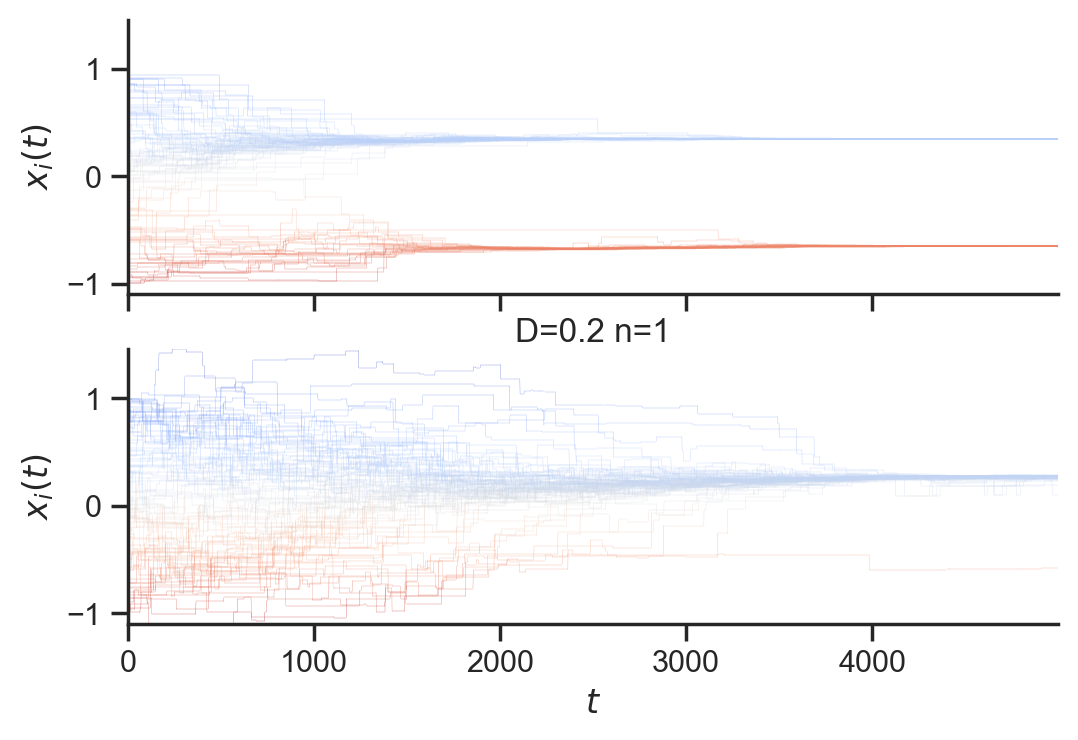

In [12]:
# no delay
# baseline and with nudge

fig, axes = plt.subplots(nrows=2, sharex=True, sharey=True)

t_max = 5000
nudge_delay = 0
nudge_strength = 0.2
nudge_sample_size = 1
nudge_method = full_nudge

seed = 1001  # same seed

data_root_dir_base = run_simulation(
    t_max=t_max,
    sns_seed=seed,
    nudge_strength=0,
    plot=False,
)

data_root_dir_nudge = run_simulation(
    t_max=t_max,
    sns_seed=seed,
    nudge_strength=nudge_strength,
    nudge_sample_size=nudge_sample_size,
    nudge_method=nudge_method,
    nudge_delay=nudge_delay,
    plot=False,
)

opinions_base = load_opinions(data_root_dir_base)
opinions_nudge = load_opinions(data_root_dir_nudge)

vmin = min(opinions_base.values.min(), opinions_nudge.values.min())
vmax = max(opinions_base.values.max(), opinions_nudge.values.max())

kwargs = dict(color_code="line", subsample=1, vmin=vmin, vmax=vmax, fig=fig)
plot_agents(opinions_base, ax=axes[0], **kwargs)
plot_agents(opinions_nudge, ax=axes[1], **kwargs)

axes[0].set_xlabel("")
axes[1].set_title(f"D={nudge_strength} n={nudge_sample_size}", va="top")


num_peaks=1
num_peaks=1


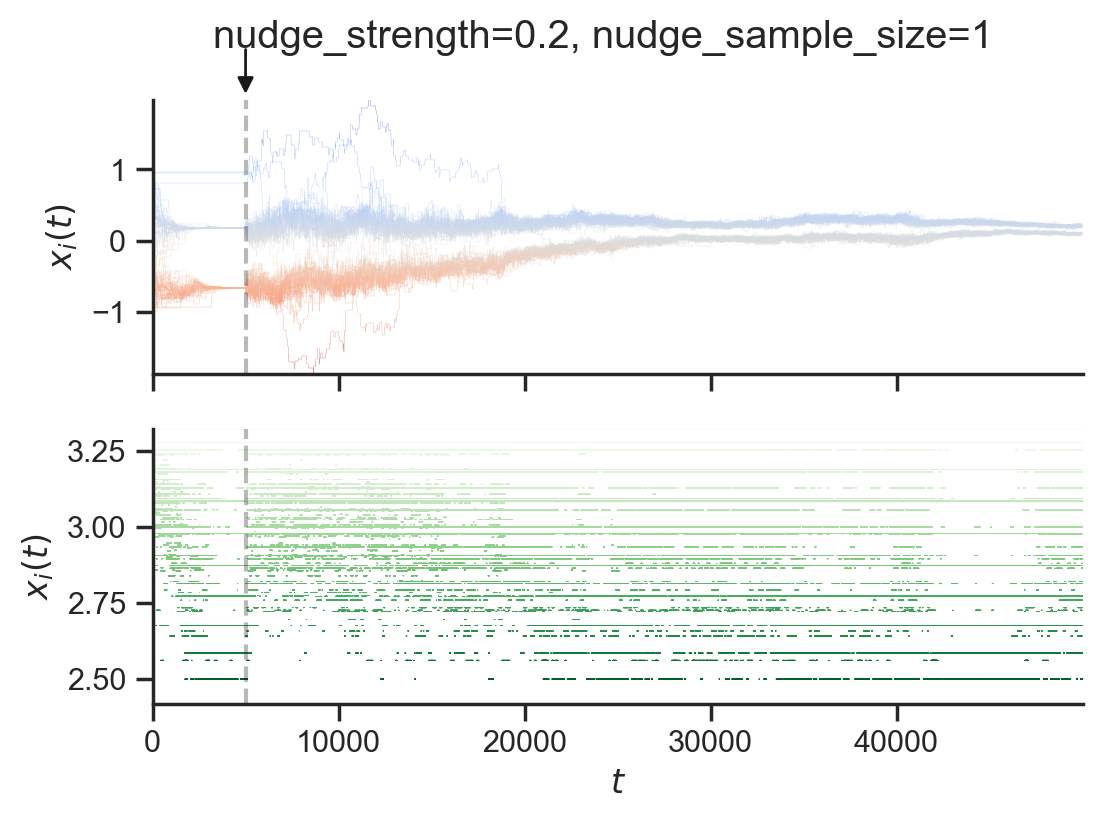

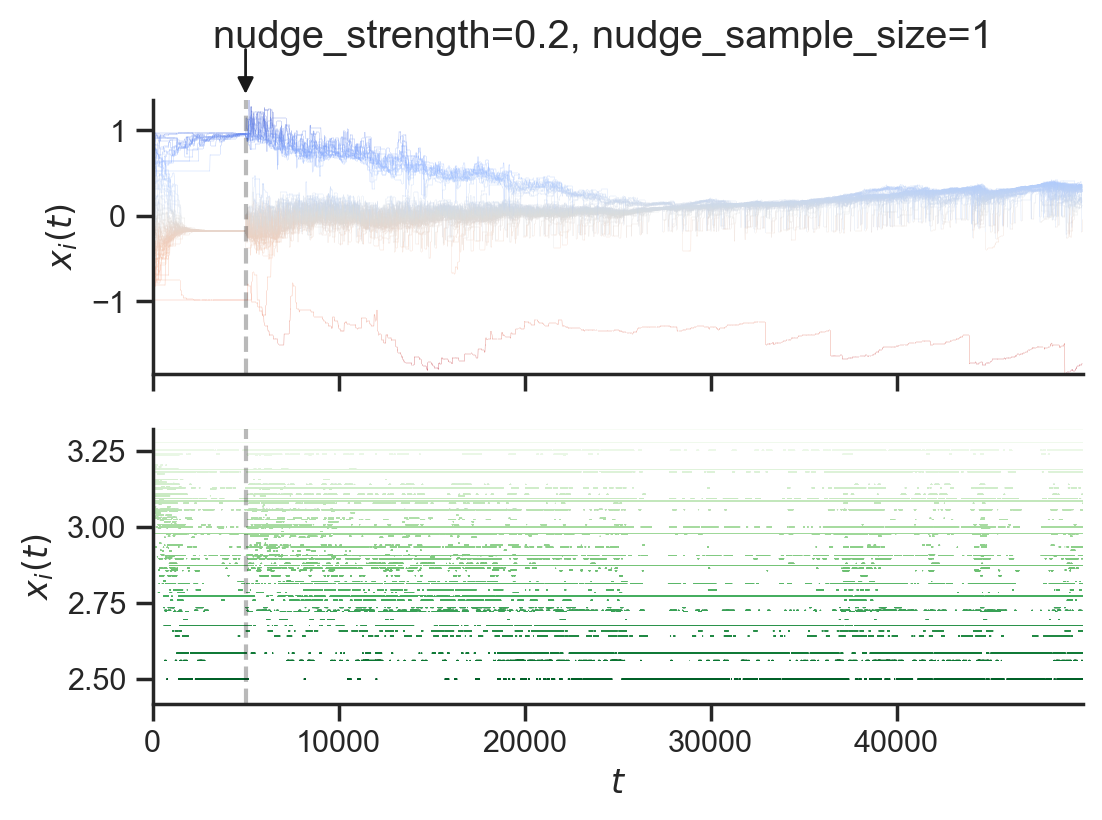

In [14]:
t_max = 50000
nudge_delay = 5000
nudge_strength = 0.2
nudge_sample_size = 1
nudge_method = full_nudge

data_root_dir_delay_1 = run_simulation(
        t_max=t_max,
        sns_seed=926814,
        nudge_strength=0.2,
        nudge_sample_size=1,
        nudge_method=nudge_method,
        nudge_delay=nudge_delay,
        plot=True,
        save_plot=False
    )
num_peaks = num_opinion_peaks(load_opinions(data_root_dir_delay_1).iloc[-1])
print(f"num_peaks={num_peaks}")
data_root_dir_delay_2 = run_simulation(
            t_max=t_max,
            sns_seed=147658,
            nudge_strength=nudge_strength,
            nudge_sample_size=nudge_sample_size,
            nudge_method=nudge_method,
            nudge_delay=nudge_delay,
            plot=True,
            save_plot=False
        )
num_peaks = num_opinion_peaks(load_opinions(data_root_dir_delay_2).iloc[-1])
print(f"num_peaks={num_peaks}")


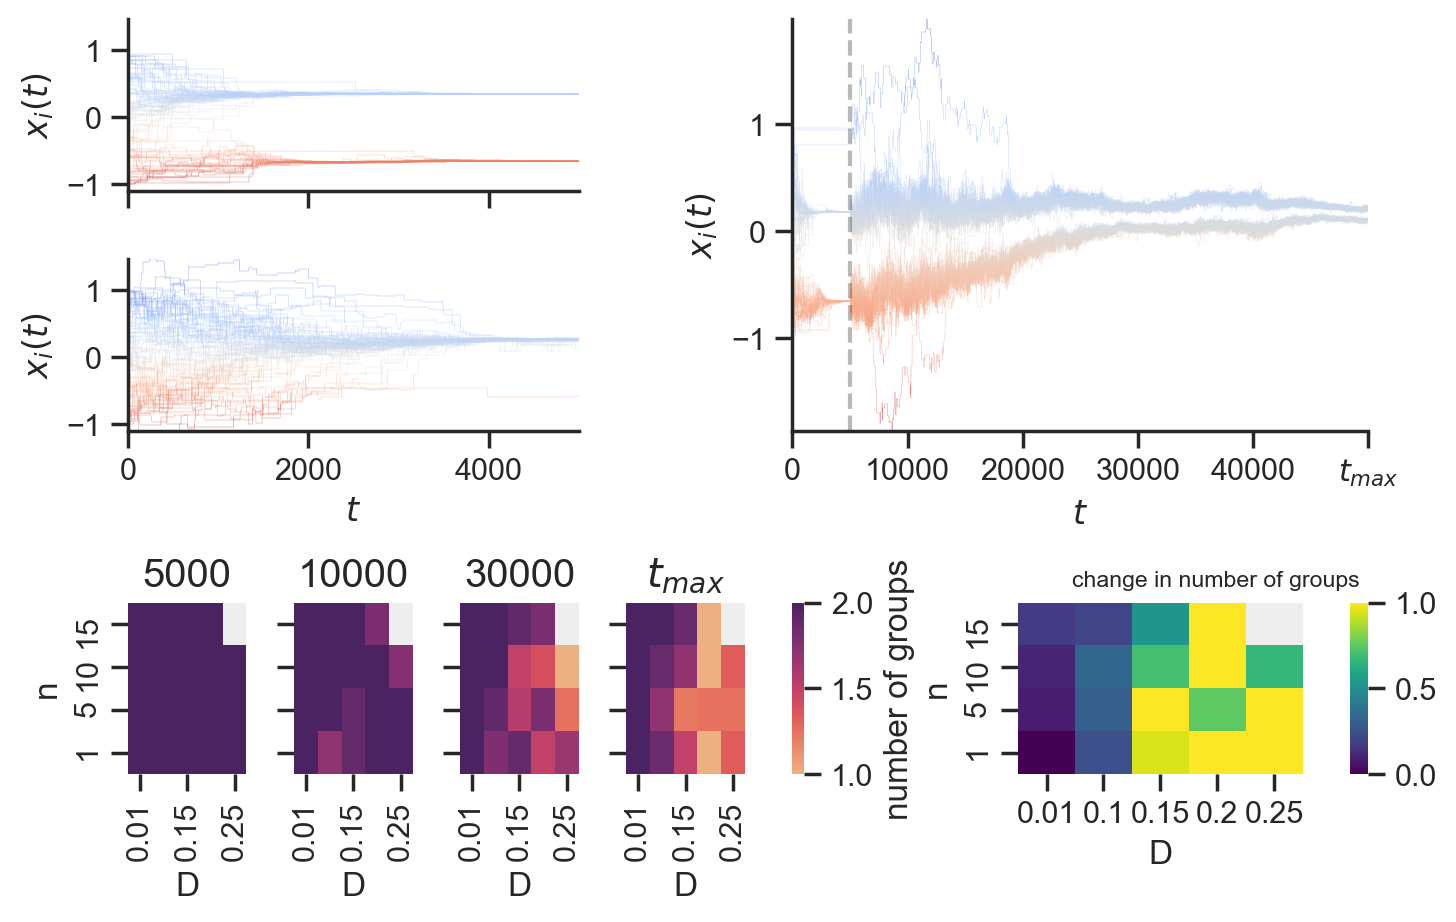

In [22]:
vis_t_points = t_points[:2] + [t_points[len(t_points) // 2]] + t_points[-1:]
# fig, axes = plt.subplots(
#     ncols=len(vis_t_points), sharex=True, sharey=True, figsize=(5, 2)
# )

fig, axes = plt.subplot_mosaic(
    [
        ["Ai"] * 3 + ["."] + ["B"] * 5,
        ["Aii"] * 3 + ["."] + ["B"] * 5,
        ["."] * 9,
        ["Ci", "Cii", "Ciii", "Civ", "Ccolorbar"] + ["."] + ["D"] * 2 + ["Dcolorbar"],
    ],
    gridspec_kw={
        "width_ratios": [1, 1, 1, 1, 0.1, 1, 1, 1, 0.15],
        "height_ratios": [1, 1, 0.2, 1],
        "wspace": 0.5,
        "hspace": 0.5,
    },
    figsize=(8, 5),
)


t_axes = [ax for key, ax in axes.items() if "Ci" in key]
ax_colorbar = axes["Ccolorbar"]
###############################################################################
# A - baseline vs immediate nudge
###############################################################################
opinions_base = load_opinions(data_root_dir_base)
opinions_nudge = load_opinions(data_root_dir_nudge)

vmin = min(opinions_base.values.min(), opinions_nudge.values.min())
vmax = max(opinions_base.values.max(), opinions_nudge.values.max())

kwargs = dict(color_code="line", subsample=1, vmin=vmin, vmax=vmax, fig=fig)
plot_agents(opinions_base, ax=axes["Ai"], **kwargs)
plot_agents(opinions_nudge, ax=axes["Aii"], **kwargs)

axes["Ai"].set(xlabel="", xticklabels=[])

###############################################################################
# B - delayed nudge (2 examples)
###############################################################################
opinions_1 = load_opinions(data_root_dir_delay_1)
opinions_2 = load_opinions(data_root_dir_delay_2)

vmin = min(opinions_1.values.min(), opinions_2.values.min())
vmax = max(opinions_1.values.max(), opinions_nudge.values.max())

kwargs = dict(color_code="line", subsample=1, vmin=vmin, vmax=vmax, fig=fig)
plot_agents(opinions_1, ax=axes["B"], **kwargs)
# plot_agents(opinions_2, ax=axes["Bii"], **kwargs)
xticks = list(range(0, t_max+2, 10000))
xticklabels = xticks[:-1] + ["$t_{max}$"]
axes["B"].set(xlim=(0, t_max+1), xticks=xticks, xticklabels=xticklabels)

# axes["Bi"].set(xlabel="", xticklabels=[])

for key, ax in axes.items():
    if "B" in key:
        ax.set_clip_on(False)
        ax.axvline(nudge_delay, color="k", alpha=0.3, ls="--")
        ax.annotate(
            "",
            xy=(nudge_delay, opinions.values.max()),
            xytext=(0, 20),
            textcoords="offset points",
            arrowprops=dict(arrowstyle="-|>", color="k"),
            clip_on=False,
            ha="center",
            va="top",
        )

###############################################################################
# C and D heatmaps over time
###############################################################################
vmin = max(1, df_avg_peaks["num_peaks"].min())
vmax = min(2, df_avg_peaks["num_peaks"].max())
for t, ax in zip(vis_t_points, t_axes):
    df_wide = (
        df_avg_peaks[df_avg_peaks["time"] == t]
        .rename(columns=COL_MAPPING)
        .pivot("n", "D", COL_MAPPING["num_peaks"])
    )
    df_wide.columns = df_wide.columns.astype(float)
    df_wide.index = df_wide.index.astype(int)
    df_wide = df_wide.sort_index(axis=1).sort_index(axis=0)
    df_wide.columns = [f"{x:.2f}" for x in df_wide.columns]

    df_wide_std = (
        df_avg_peaks[df_avg_peaks["time"] == t]
        .rename(columns=COL_MAPPING)
        .pivot("n", "D", COL_MAPPING["num_peaks_std"])
    )
    df_wide_std.columns = df_wide_std.columns.astype(float)
    df_wide_std.index = df_wide_std.index.astype(int)
    df_wide_std = df_wide_std.sort_index(axis=1).sort_index(axis=0)
    df_wide_std.columns = [f"{x:.2f}" for x in df_wide_std.columns]

    sns.heatmap(
        df_wide.iloc[::-1],
        vmin=vmin,
        vmax=vmax,
        mask=df_wide.iloc[::-1].isna(),
        cmap="flare",
        ax=ax,
        cbar=ax == t_axes[-1],
        cbar_ax=ax_colorbar,
        cbar_kws={"label": "number of groups"},
        annot=False,
        fmt=".1f",
    )
    ax.set_facecolor("#eeeeee")  # missing values
    if ax != t_axes[0]:
        ax.set(ylabel="", yticklabels=[])
    ax.set_xlabel("D")
    if ax == t_axes[-1]:
        ax.set_title("$t_{max}$", fontsize="large")

    else:
        ax.set_title(f"{t}", fontsize="large")


df_peak_wide = df_peak_decrease.rename(columns=COL_MAPPING).pivot(
    "n", "D", values=COL_MAPPING["peak_decrease"]
)
df_peak_wide.columns = df_peak_wide.columns.astype(float)
df_peak_wide.index = df_peak_wide.index.astype(int)
df_peak_wide = df_peak_wide.sort_index(axis=1).sort_index(axis=0)
vals = df_peak_wide.iloc[::-1].abs()

g = sns.heatmap(
    vals,
    mask=vals.isna(),
    cmap="viridis",
    vmax=1,
    cbar_ax=axes["Dcolorbar"],
    # cbar_kws={"label": "change in number of groups"},
    ax=axes["D"],
)
axes["Dcolorbar"].set_title(
    "change in number of groups", fontsize="x-small", ha="right"
)
g.set_facecolor("#eeeeee")  # missing values
fig.savefig("output/social_influence_model.svg", bbox_inches="tight", transparent=True)